# Contrastive Representation Distillation Experiments
## Comparing Baseline SupCon vs Logit-Weighted SupCRD

**Goal**: Evaluate whether using teacher logits to weight contrastive forces improves student representation quality.

**Methods**:
- **Baseline**: Standard Supervised Contrastive Learning (SupCon)
- **SupCRD (Original)**: Logit-Weighted Supervised Contrastive Representation Distillation
  - Pull weight: `α × P_teacher(target_class)`
  - Push weight: `β × (1 - P_teacher(negative_class))`
- **SupCRD (Balanced)**: Force-balanced version with automatic normalization

---
## Setup & Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---
## Hyperparameters

In [2]:
# Training config
BATCH_SIZE = 128
LR = 1e-3
EPOCHS_TEACHER = 10
EPOCHS_STUDENT = 20

# Contrastive config
TEMP = 0.07

# Distillation config
ALPHA = 1.0  # Pull force weight
BETA = 10.0  # Push force weight

---
## Data Loading (CIFAR-10)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

100%|██████████| 170M/170M [02:43<00:00, 1.04MB/s] 


Train samples: 50000
Test samples: 10000


---
## Model Architecture

In [4]:
class ConvEncoder(nn.Module):
    """Simple CNN Encoder outputting a flat feature vector."""
    def __init__(self, feature_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flat_dim = 128 * 4 * 4
        self.fc = nn.Linear(self.flat_dim, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ModelWrapper(nn.Module):
    """Wraps Encoder, Projection Head, and Classifier."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.encoder = ConvEncoder(feature_dim=128)
        self.projector = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64) 
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        feats = self.encoder(x)
        proj = self.projector(feats)
        logits = self.classifier(feats)
        return feats, proj, logits

---
## Loss Functions

In [5]:
class LogitWeightedSupCRDLoss(nn.Module):
    """
    Original Logit-Weighted Supervised Contrastive Representation Distillation.
    
    Uses teacher probabilities to weight contrastive forces:
    - Pull: α × P_teacher(target_class)
    - Push: β × (1 - P_teacher(negative_class))
    """
    def __init__(self, alpha=1.0, beta=1.0, temperature=0.07, eps=1e-8):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.tau = temperature
        self.eps = eps

    def forward(self, student_features, teacher_features, teacher_logits, labels):
        batch_size = student_features.shape[0]
        device = student_features.device

        # 1. Normalize features
        s_norm = F.normalize(student_features, dim=1)
        t_norm = F.normalize(teacher_features, dim=1)

        # 2. Similarity Matrix
        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.tau
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)

        # 3. Teacher Probabilities
        teacher_probs = F.softmax(teacher_logits, dim=1)

        # 4. Construct Masks
        labels = labels.view(-1, 1)
        mask_pos = torch.eq(labels, labels.T).float().to(device)
        mask_neg = 1.0 - mask_pos

        # 5. Compute Weights
        p_target = torch.gather(teacher_probs, 1, labels).view(-1)
        w_pull = self.alpha * p_target
        
        target_labels_expand = labels.view(1, -1).expand(batch_size, -1)
        p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
        w_push = self.beta * (1.0 - p_negative_class)

        # 6. Compute Loss
        sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
        numerator_term = w_pull * sum_pos_exp
        weighted_neg_exp = (exp_sim * w_push * mask_neg).sum(dim=1)
        denominator_term = numerator_term + weighted_neg_exp

        loss = -torch.log((numerator_term + self.eps) / (denominator_term + self.eps))
        return loss.mean()


class BalancedLogitWeightedSupCRDLoss(nn.Module):
    """
    Balanced version with automatic force normalization.
    
    Ensures Sum(Push Forces) = Pull Force for each anchor.
    This makes the loss batch-size invariant and truly decouples α and β.
    """
    def __init__(self, alpha=1.0, beta=1.0, temperature=0.07, eps=1e-8):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.tau = temperature
        self.eps = eps

    def forward(self, student_features, teacher_features, teacher_logits, labels):
        batch_size = student_features.shape[0]
        device = student_features.device

        # 1. Normalize features & Compute Similarity
        s_norm = F.normalize(student_features, dim=1)
        t_norm = F.normalize(teacher_features, dim=1)
        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.tau
        
        # Stability
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)

        # 2. Masks
        labels = labels.view(-1, 1)
        mask_pos = torch.eq(labels, labels.T).float().to(device)
        mask_neg = 1.0 - mask_pos

        # 3. Compute Base Weights (from Teacher)
        teacher_probs = F.softmax(teacher_logits, dim=1)
        
        # Pull Weight (Alpha * P_target)
        p_target = torch.gather(teacher_probs, 1, labels).view(-1)
        w_pull = self.alpha * p_target
        
        # Push Weight (Beta * (1 - P_neg))
        target_labels_expand = labels.view(1, -1).expand(batch_size, -1)
        p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
        w_push_raw = self.beta * (1.0 - p_negative_class)

        # --- FORCE BALANCING (Normalization) ---
        # Calculate total "mass" of push weights for each anchor
        total_push_mass = (w_push_raw * mask_neg).sum(dim=1)
        
        # Normalization: Pull / Total_Push
        norm_factor = w_pull / (total_push_mass + self.eps)
        w_push_balanced = w_push_raw * norm_factor.view(-1, 1)

        # 4. Compute Loss Terms
        sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
        numerator_term = w_pull * sum_pos_exp
        
        weighted_neg_exp = (exp_sim * w_push_balanced * mask_neg).sum(dim=1)
        denominator_term = numerator_term + weighted_neg_exp

        # 5. Log-Likelihood
        loss = -torch.log((numerator_term + self.eps) / (denominator_term + self.eps))
        return loss.mean()


class SupConLoss(nn.Module):
    """BASELINE: Standard Supervised Contrastive Loss (Student vs Student)"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature

    def forward(self, student_proj, labels):
        feats = F.normalize(student_proj, dim=1)
        sim_matrix = torch.matmul(feats, feats.T) / self.temp
        
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        # Remove self-contrast
        logits_mask = torch.scatter(torch.ones_like(mask), 1, 
                                    torch.arange(feats.shape[0]).view(-1, 1).to(device), 0)
        mask = mask * logits_mask
        
        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - logits_max.detach()
        
        exp_logits = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_logits.sum(1, keepdim=True))
        
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        return -mean_log_prob_pos.mean()

---
## Visualization: t-SNE Latent Space

In [6]:
def visualize_latents(model, loader, title="Latent Space", save_path=None):
    """Runs t-SNE on model features and plots them."""
    model.eval()
    features_list = []
    labels_list = []
    num_samples = 2000
    count = 0
    
    print(f"[{title}] Extracting features...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats, _, _ = model(images)
            feats = feats.view(feats.size(0), -1).cpu()
            
            features_list.append(feats)
            labels_list.append(labels)
            
            count += images.size(0)
            if count >= num_samples:
                break

    X = torch.cat(features_list, dim=0).numpy()[:num_samples]
    y = torch.cat(labels_list, dim=0).numpy()[:num_samples]

    print(f"[{title}] Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    cifar_classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    
    sns.scatterplot(
        x=X_embedded[:, 0], y=X_embedded[:, 1], 
        hue=y, palette='tab10', legend='full', alpha=0.7
    )
    plt.legend(title='Classes', labels=cifar_classes, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"{title} (t-SNE)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    
    plt.show()

---
## Analysis: Pull vs Push Forces

In [7]:
def analyze_pull_push_forces(model, teacher_model, loader, loss_fn, num_batches=10):
    """
    Analyze pull vs push forces for the loss function.
    Returns statistics on force magnitudes.
    """
    model.eval()
    teacher_model.eval()
    
    pull_forces = []
    push_forces = []
    pull_weights = []
    push_weights = []
    
    batch_count = 0
    
    with torch.no_grad():
        for images, labels in loader:
            if batch_count >= num_batches:
                break
                
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            s_feats, s_proj, _ = model(images)
            _, t_proj, t_logits = teacher_model(images)
            
            batch_size = s_proj.shape[0]
            
            s_norm = F.normalize(s_proj, dim=1)
            t_norm = F.normalize(t_proj, dim=1)
            
            sim_matrix = torch.matmul(s_norm, t_norm.T) / loss_fn.tau
            exp_sim = torch.exp(sim_matrix)
            
            teacher_probs = F.softmax(t_logits, dim=1)
            
            labels_view = labels.view(-1, 1)
            mask_pos = torch.eq(labels_view, labels_view.T).float()
            mask_neg = 1.0 - mask_pos
            
            p_target = torch.gather(teacher_probs, 1, labels_view).view(-1)
            w_pull = loss_fn.alpha * p_target
            
            target_labels_expand = labels_view.view(1, -1).expand(batch_size, -1)
            p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
            w_push = loss_fn.beta * (1.0 - p_negative_class)
            
            sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
            pull_force = w_pull * sum_pos_exp
            
            weighted_neg_exp = (exp_sim * w_push * mask_neg).sum(dim=1)
            push_force = weighted_neg_exp
            
            pull_forces.extend(pull_force.cpu().numpy())
            push_forces.extend(push_force.cpu().numpy())
            pull_weights.extend(w_pull.cpu().numpy())
            push_weights.extend(w_push.mean(dim=1).cpu().numpy())
            
            batch_count += 1
    
    pull_forces = np.array(pull_forces)
    push_forces = np.array(push_forces)
    pull_weights = np.array(pull_weights)
    push_weights = np.array(push_weights)
    
    return {
        'pull_force': {
            'mean': pull_forces.mean(),
            'std': pull_forces.std(),
            'min': pull_forces.min(),
            'max': pull_forces.max()
        },
        'push_force': {
            'mean': push_forces.mean(),
            'std': push_forces.std(),
            'min': push_forces.min(),
            'max': push_forces.max()
        },
        'pull_weight': {
            'mean': pull_weights.mean(),
            'std': pull_weights.std()
        },
        'push_weight': {
            'mean': push_weights.mean(),
            'std': push_weights.std()
        },
        'ratio_pull_to_push': pull_forces.mean() / push_forces.mean()
    }


def find_balanced_beta(teacher, loader, alpha=1.0, temperature=0.07, num_batches=50):
    """
    Find the β value that balances pull and push forces on average.
    Returns: optimal β such that mean(pull_force) ≈ mean(push_force)
    """
    teacher.eval()
    
    pull_ratios = []
    
    with torch.no_grad():
        batch_count = 0
        for images, labels in loader:
            if batch_count >= num_batches:
                break
                
            images, labels = images.to(device), labels.to(device)
            
            _, t_proj, t_logits = teacher(images)
            batch_size = t_proj.shape[0]
            
            t_norm = F.normalize(t_proj, dim=1)
            sim_matrix = torch.matmul(t_norm, t_norm.T) / temperature
            exp_sim = torch.exp(sim_matrix)
            
            teacher_probs = F.softmax(t_logits, dim=1)
            
            labels_view = labels.view(-1, 1)
            mask_pos = torch.eq(labels_view, labels_view.T).float()
            mask_neg = 1.0 - mask_pos
            
            p_target = torch.gather(teacher_probs, 1, labels_view).view(-1)
            w_pull = alpha * p_target
            
            target_labels_expand = labels_view.view(1, -1).expand(batch_size, -1)
            p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand)
            w_push_base = (1.0 - p_negative_class)
            
            sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
            pull_force = w_pull * sum_pos_exp
            
            push_force_base = (exp_sim * w_push_base * mask_neg).sum(dim=1)
            
            ratio = pull_force / (push_force_base + 1e-8)
            pull_ratios.extend(ratio.cpu().numpy())
            batch_count += 1
    
    optimal_beta = np.mean(pull_ratios)
    
    print(f"\n{'='*70}")
    print(f"OPTIMAL β CALCULATION (for α={alpha})")
    print(f"{'='*70}")
    print(f"Mean ratio (Pull/Push_base): {optimal_beta:.4f}")
    print(f"Std deviation: {np.std(pull_ratios):.4f}")
    print(f"\nRecommendation: Set β = {optimal_beta:.4f} to balance forces")
    print(f"{'='*70}\n")
    
    return optimal_beta

---
## Analysis: Semantic Similarity

In [8]:
def compute_semantic_similarities(model, loader, class_pairs):
    """
    Compute average similarity between specific class pairs.
    
    Args:
        class_pairs: list of tuples like [('dog', 'cat'), ('dog', 'car'), ...]
    
    Returns:
        dict: {"dog-cat": similarity_score, ...}
    """
    model.eval()
    
    class_names = ['plane', 'car', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Collect features per class
    class_features = {i: [] for i in range(10)}
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats, _, _ = model(images)
            feats = F.normalize(feats, dim=1)
            
            for i in range(len(labels)):
                class_features[labels[i].item()].append(feats[i].cpu())
    
    # Average features per class (centroid)
    class_centroids = {}
    for cls_idx, feats_list in class_features.items():
        if len(feats_list) > 0:
            class_centroids[cls_idx] = torch.stack(feats_list).mean(dim=0)
    
    # Compute similarities
    results = {}
    for cls1_name, cls2_name in class_pairs:
        cls1_idx = class_names.index(cls1_name)
        cls2_idx = class_names.index(cls2_name)
        
        sim = F.cosine_similarity(
            class_centroids[cls1_idx].unsqueeze(0),
            class_centroids[cls2_idx].unsqueeze(0)
        ).item()
        
        results[f"{cls1_name}-{cls2_name}"] = sim
    
    return results

---
## Training Functions

In [9]:
def train_teacher(epochs=10):
    """Train teacher model with standard cross-entropy."""
    model = ModelWrapper(num_classes=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    
    print(f"\n{'='*60}")
    print(f"TRAINING TEACHER MODEL ({epochs} epochs)")
    print(f"{'='*60}")
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            _, _, logits = model(images)
            loss = criterion(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        avg_loss = total_loss / len(train_loader)
        acc = 100. * correct / total
        print(f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.3f} | Acc={acc:.1f}%")
    
    print(f"\n✓ Teacher training complete: {acc:.1f}% accuracy\n")
    return model


def train_student(teacher_model, mode="supcon", epochs=20, alpha=1.0, beta=1.0, temperature=0.07):
    """
    Train student with contrastive loss.
    
    Args:
        mode: 'supcon' (baseline), 'supcrd' (logit-weighted), or 'balanced_supcrd'
    """
    student = ModelWrapper(num_classes=10).to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=LR)
    
    # Online Linear Probe
    probe_head = nn.Linear(128, 10).to(device) 
    probe_opt = torch.optim.Adam(probe_head.parameters(), lr=LR)
    probe_crit = nn.CrossEntropyLoss()

    # Select loss
    if mode == "supcrd":
        criterion = LogitWeightedSupCRDLoss(alpha=alpha, beta=beta, temperature=temperature)
        print(f"\n{'='*60}")
        print(f"TRAINING: Logit-Weighted SupCRD (Original)")
        print(f"α={alpha} (pull) | β={beta} (push) | τ={temperature}")
        print(f"{'='*60}\n")
    elif mode == "balanced_supcrd":
        criterion = BalancedLogitWeightedSupCRDLoss(alpha=alpha, beta=beta, temperature=temperature)
        print(f"\n{'='*60}")
        print(f"TRAINING: Balanced SupCRD (Force-Normalized)")
        print(f"α={alpha} (pull) | β={beta} (push) | τ={temperature}")
        print(f"{'='*60}\n")
    else:
        criterion = SupConLoss(temperature=temperature)
        print(f"\n{'='*60}")
        print(f"TRAINING: Baseline SupCon")
        print(f"τ={temperature}")
        print(f"{'='*60}\n")

    training_log = {
        'epochs': [],
        'loss': [],
        'probe_acc': []
    }

    for epoch in range(epochs):
        student.train()
        probe_head.train()
        total_loss = 0
        probe_acc = 0
        total_samples = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            s_feats, s_proj, _ = student(images)
            
            if mode in ["supcrd", "balanced_supcrd"]:
                with torch.no_grad():
                    _, t_proj, t_logits = teacher_model(images)
                loss = criterion(s_proj, t_proj, t_logits, labels)
            else:
                loss = criterion(s_proj, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            probe_logits = probe_head(s_feats.detach()) 
            p_loss = probe_crit(probe_logits, labels)
            
            probe_opt.zero_grad()
            p_loss.backward()
            probe_opt.step()
            
            total_loss += loss.item()
            _, preds = probe_logits.max(1)
            probe_acc += preds.eq(labels).sum().item()
            total_samples += labels.size(0)
            
        avg_loss = total_loss / len(train_loader)
        avg_acc = 100. * probe_acc / total_samples
        
        training_log['epochs'].append(epoch + 1)
        training_log['loss'].append(avg_loss)
        training_log['probe_acc'].append(avg_acc)
        
        print(f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.4f} | Probe Acc={avg_acc:.2f}%")
    
    print(f"\n✓ Student training complete: {avg_acc:.2f}% accuracy\n")
    return student, training_log

---
---
# EXPERIMENTS
---

## Experiment 0: Train Teacher Model


TRAINING TEACHER MODEL (10 epochs)
Epoch  1/10: Loss=1.428 | Acc=48.6%
Epoch  2/10: Loss=1.015 | Acc=64.3%
Epoch  3/10: Loss=0.842 | Acc=70.6%
Epoch  4/10: Loss=0.731 | Acc=74.6%
Epoch  5/10: Loss=0.648 | Acc=77.6%
Epoch  6/10: Loss=0.572 | Acc=80.1%
Epoch  7/10: Loss=0.508 | Acc=82.4%
Epoch  8/10: Loss=0.454 | Acc=84.1%
Epoch  9/10: Loss=0.403 | Acc=85.8%
Epoch 10/10: Loss=0.351 | Acc=87.7%

✓ Teacher training complete: 87.7% accuracy

[Teacher Model] Extracting features...
[Teacher Model] Running t-SNE...
Saved plot to teacher_latent.png


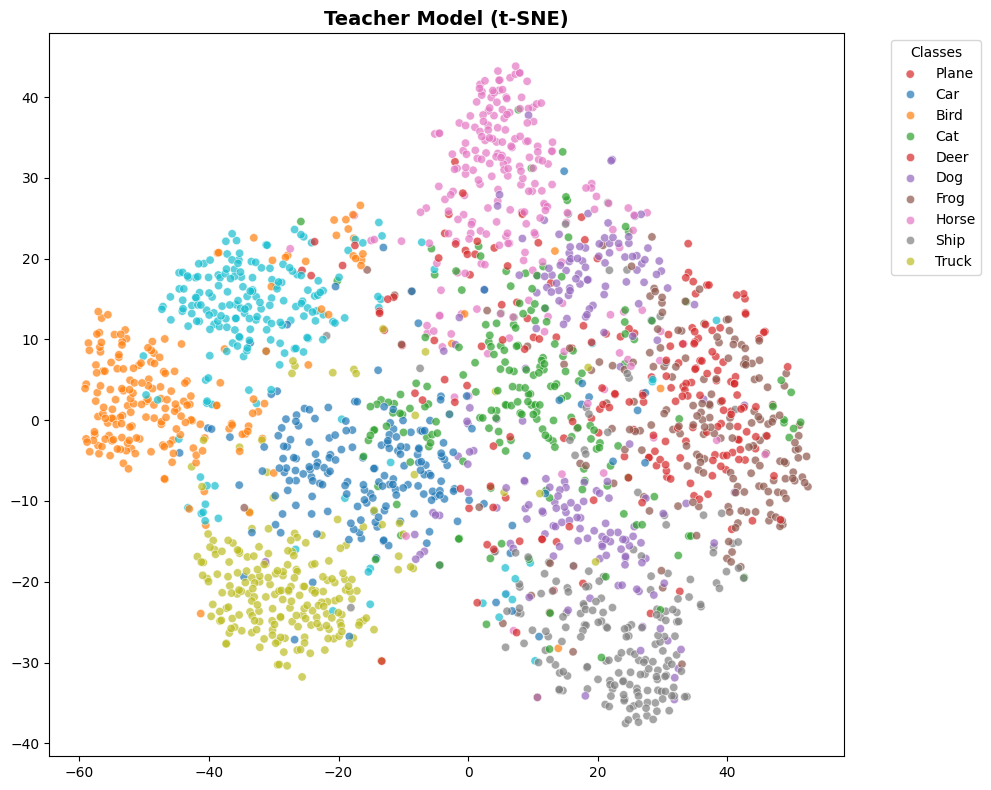

In [10]:
teacher = train_teacher(epochs=EPOCHS_TEACHER)
teacher.eval()

visualize_latents(teacher, test_loader, 
                  title="Teacher Model",
                  save_path="teacher_latent.png")

## Experiment 1: Find Optimal Beta

In [11]:
# Find what beta would balance forces for alpha=1.0
optimal_beta = find_balanced_beta(teacher, train_loader, alpha=1.0, temperature=0.07)


OPTIMAL β CALCULATION (for α=1.0)
Mean ratio (Pull/Push_base): 5.8515
Std deviation: 7.8231

Recommendation: Set β = 5.8515 to balance forces



## Experiment 2: Baseline SupCon


TRAINING: Baseline SupCon
τ=0.07

Epoch  1/20: Loss=4.3985 | Probe Acc=37.53%
Epoch  2/20: Loss=4.0538 | Probe Acc=59.75%
Epoch  3/20: Loss=3.8498 | Probe Acc=68.72%
Epoch  4/20: Loss=3.7070 | Probe Acc=73.57%
Epoch  5/20: Loss=3.5952 | Probe Acc=76.97%
Epoch  6/20: Loss=3.5050 | Probe Acc=79.08%
Epoch  7/20: Loss=3.4172 | Probe Acc=81.12%
Epoch  8/20: Loss=3.3418 | Probe Acc=82.87%
Epoch  9/20: Loss=3.2761 | Probe Acc=84.37%
Epoch 10/20: Loss=3.2207 | Probe Acc=85.07%
Epoch 11/20: Loss=3.1572 | Probe Acc=86.42%
Epoch 12/20: Loss=3.1147 | Probe Acc=87.16%
Epoch 13/20: Loss=3.0694 | Probe Acc=87.93%
Epoch 14/20: Loss=3.0157 | Probe Acc=88.84%
Epoch 15/20: Loss=2.9778 | Probe Acc=89.56%
Epoch 16/20: Loss=2.9570 | Probe Acc=89.81%
Epoch 17/20: Loss=2.9262 | Probe Acc=90.02%
Epoch 18/20: Loss=2.8937 | Probe Acc=90.76%
Epoch 19/20: Loss=2.8794 | Probe Acc=90.99%
Epoch 20/20: Loss=2.8468 | Probe Acc=91.62%

✓ Student training complete: 91.62% accuracy

[Baseline SupCon] Extracting features.

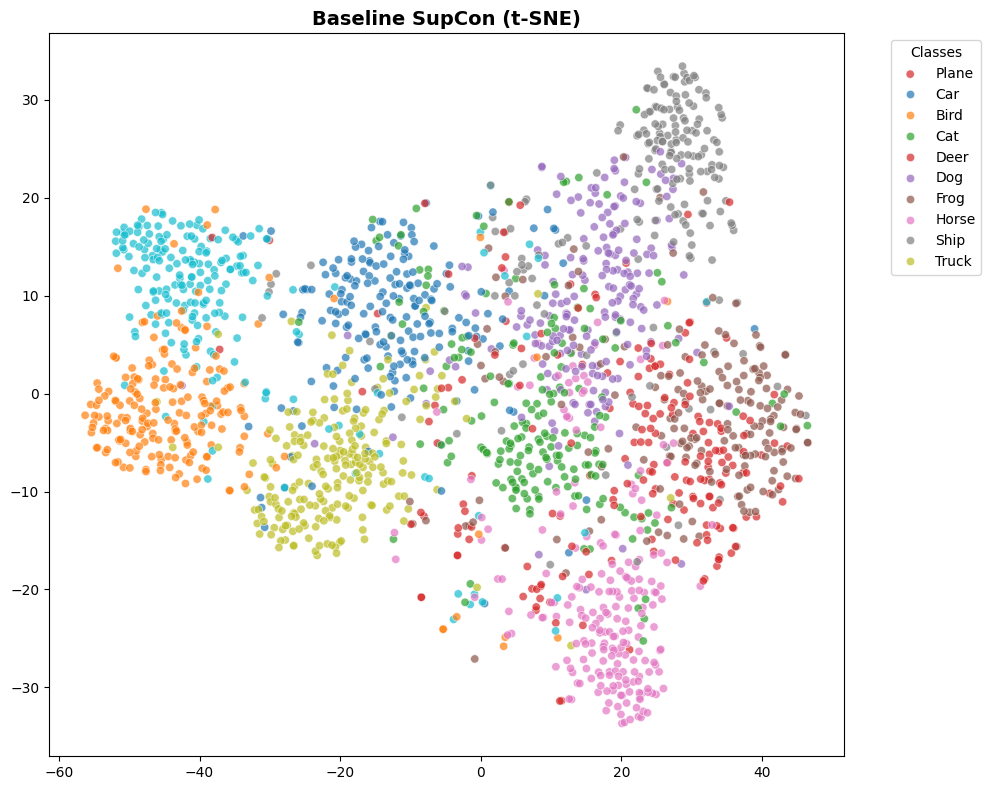

In [12]:
baseline_student, baseline_log = train_student(
    teacher_model=teacher,
    mode="supcon",
    epochs=EPOCHS_STUDENT,
    temperature=0.07
)

visualize_latents(baseline_student, test_loader,
                  title="Baseline SupCon",
                  save_path="baseline_supcon_latent.png")

## Experiment 3: SupCRD (Original) - With Optimal β


TRAINING: Logit-Weighted SupCRD (Original)
α=1.0 (pull) | β=5.851527690887451 (push) | τ=0.07

Epoch  1/20: Loss=2.7703 | Probe Acc=44.72%
Epoch  2/20: Loss=1.8740 | Probe Acc=65.16%
Epoch  3/20: Loss=1.5624 | Probe Acc=71.34%
Epoch  4/20: Loss=1.3940 | Probe Acc=74.59%
Epoch  5/20: Loss=1.2869 | Probe Acc=76.87%
Epoch  6/20: Loss=1.2142 | Probe Acc=78.53%
Epoch  7/20: Loss=1.1514 | Probe Acc=79.86%
Epoch  8/20: Loss=1.0998 | Probe Acc=80.81%
Epoch  9/20: Loss=1.0662 | Probe Acc=81.75%
Epoch 10/20: Loss=1.0153 | Probe Acc=82.53%
Epoch 11/20: Loss=0.9867 | Probe Acc=83.23%
Epoch 12/20: Loss=0.9427 | Probe Acc=84.15%
Epoch 13/20: Loss=0.9211 | Probe Acc=84.56%
Epoch 14/20: Loss=0.8973 | Probe Acc=85.04%
Epoch 15/20: Loss=0.8554 | Probe Acc=85.87%
Epoch 16/20: Loss=0.8418 | Probe Acc=86.04%
Epoch 17/20: Loss=0.8193 | Probe Acc=86.59%
Epoch 18/20: Loss=0.7920 | Probe Acc=87.06%
Epoch 19/20: Loss=0.7914 | Probe Acc=86.98%
Epoch 20/20: Loss=0.7595 | Probe Acc=87.48%

✓ Student training comp

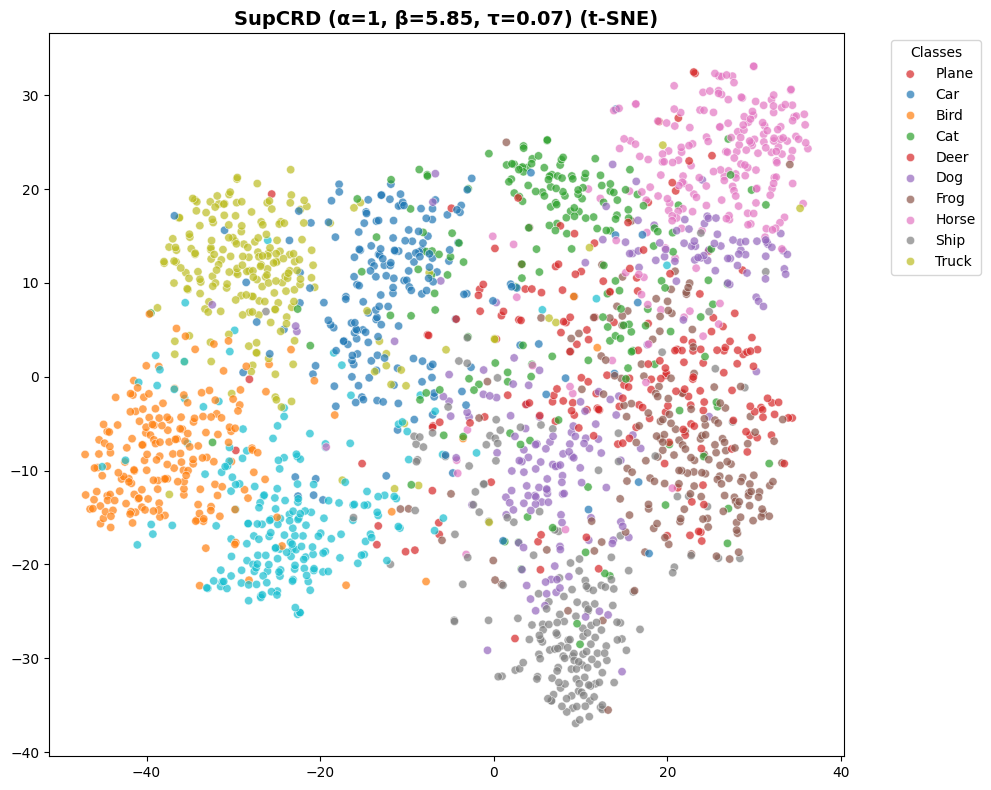

In [13]:
supcrd_student_1, supcrd_log_1 = train_student(
    teacher_model=teacher,
    mode="supcrd",
    epochs=EPOCHS_STUDENT,
    alpha=1.0,
    beta=optimal_beta,
    temperature=0.07
)

visualize_latents(supcrd_student_1, test_loader,
                  title=f"SupCRD (α=1, β={optimal_beta:.2f}, τ=0.07)",
                  save_path="supcrd_a1_bopt_t007_latent.png")

## Experiment 4: SupCRD (Original) - Low Temperature


TRAINING: Logit-Weighted SupCRD (Original)
α=1.0 (pull) | β=10.0 (push) | τ=0.007

Epoch  1/20: Loss=5.2427 | Probe Acc=25.74%
Epoch  2/20: Loss=3.3416 | Probe Acc=50.99%
Epoch  3/20: Loss=2.4668 | Probe Acc=62.01%
Epoch  4/20: Loss=1.7858 | Probe Acc=67.98%
Epoch  5/20: Loss=1.3583 | Probe Acc=71.19%
Epoch  6/20: Loss=1.0643 | Probe Acc=73.36%
Epoch  7/20: Loss=0.8923 | Probe Acc=74.28%
Epoch  8/20: Loss=0.7374 | Probe Acc=75.57%
Epoch  9/20: Loss=0.6732 | Probe Acc=76.06%
Epoch 10/20: Loss=0.5692 | Probe Acc=76.54%
Epoch 11/20: Loss=0.5139 | Probe Acc=77.28%
Epoch 12/20: Loss=0.4669 | Probe Acc=77.73%
Epoch 13/20: Loss=0.4307 | Probe Acc=77.94%
Epoch 14/20: Loss=0.4035 | Probe Acc=78.02%
Epoch 15/20: Loss=0.3726 | Probe Acc=78.13%
Epoch 16/20: Loss=0.3618 | Probe Acc=78.30%
Epoch 17/20: Loss=0.3162 | Probe Acc=78.76%
Epoch 18/20: Loss=0.2883 | Probe Acc=79.35%
Epoch 19/20: Loss=0.2767 | Probe Acc=79.48%
Epoch 20/20: Loss=0.2673 | Probe Acc=79.57%

✓ Student training complete: 79.57%

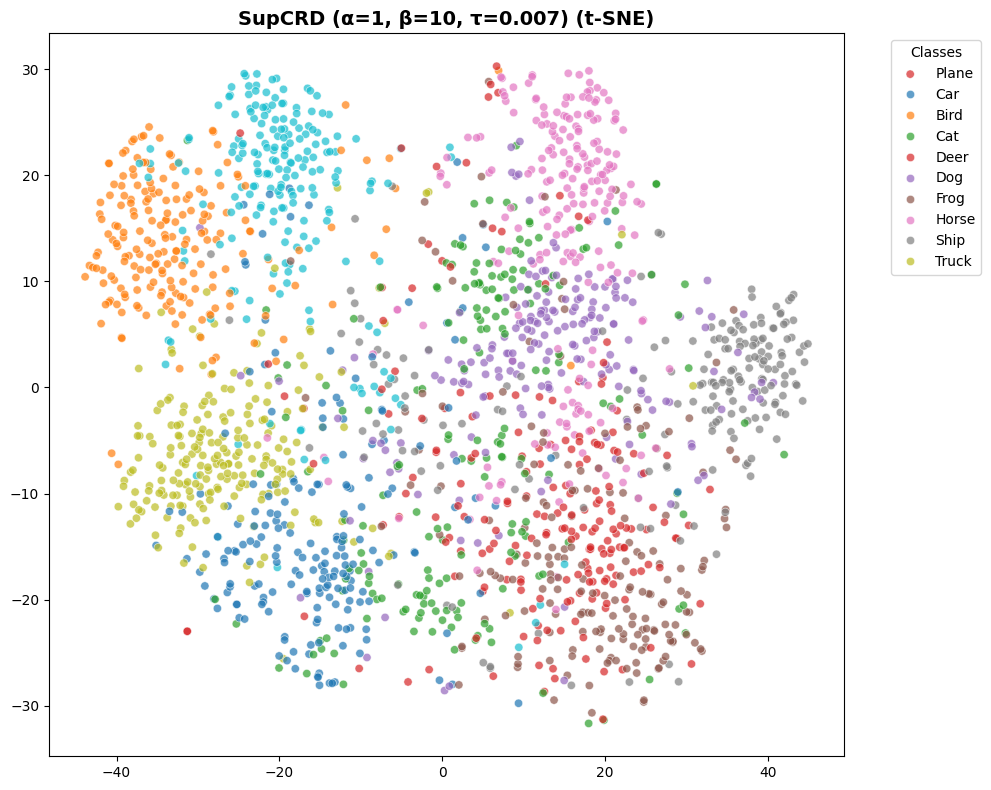

In [14]:
supcrd_student_2, supcrd_log_2 = train_student(
    teacher_model=teacher,
    mode="supcrd",
    epochs=EPOCHS_STUDENT,
    alpha=1.0,
    beta=10.0,
    temperature=0.007
)

visualize_latents(supcrd_student_2, test_loader,
                  title="SupCRD (α=1, β=10, τ=0.007)",
                  save_path="supcrd_a1_b10_t0007_latent.png")

## Experiment 5: Alpha Sweep (β=1.0, τ=0.07)


############################################################
Alpha Sweep: α=1.0
############################################################

TRAINING: Logit-Weighted SupCRD (Original)
α=1.0 (pull) | β=1.0 (push) | τ=0.07

Epoch  1/20: Loss=1.4378 | Probe Acc=46.86%
Epoch  2/20: Loss=0.8660 | Probe Acc=66.77%
Epoch  3/20: Loss=0.6709 | Probe Acc=73.07%
Epoch  4/20: Loss=0.5874 | Probe Acc=76.13%
Epoch  5/20: Loss=0.5255 | Probe Acc=78.16%
Epoch  6/20: Loss=0.4833 | Probe Acc=79.91%
Epoch  7/20: Loss=0.4443 | Probe Acc=81.15%
Epoch  8/20: Loss=0.4214 | Probe Acc=82.14%
Epoch  9/20: Loss=0.3978 | Probe Acc=83.22%
Epoch 10/20: Loss=0.3775 | Probe Acc=84.02%
Epoch 11/20: Loss=0.3649 | Probe Acc=84.72%
Epoch 12/20: Loss=0.3514 | Probe Acc=85.45%
Epoch 13/20: Loss=0.3322 | Probe Acc=86.19%
Epoch 14/20: Loss=0.3192 | Probe Acc=86.91%
Epoch 15/20: Loss=0.3135 | Probe Acc=87.17%
Epoch 16/20: Loss=0.2965 | Probe Acc=87.92%
Epoch 17/20: Loss=0.2864 | Probe Acc=88.31%
Epoch 18/20: Loss=0.2777 | P

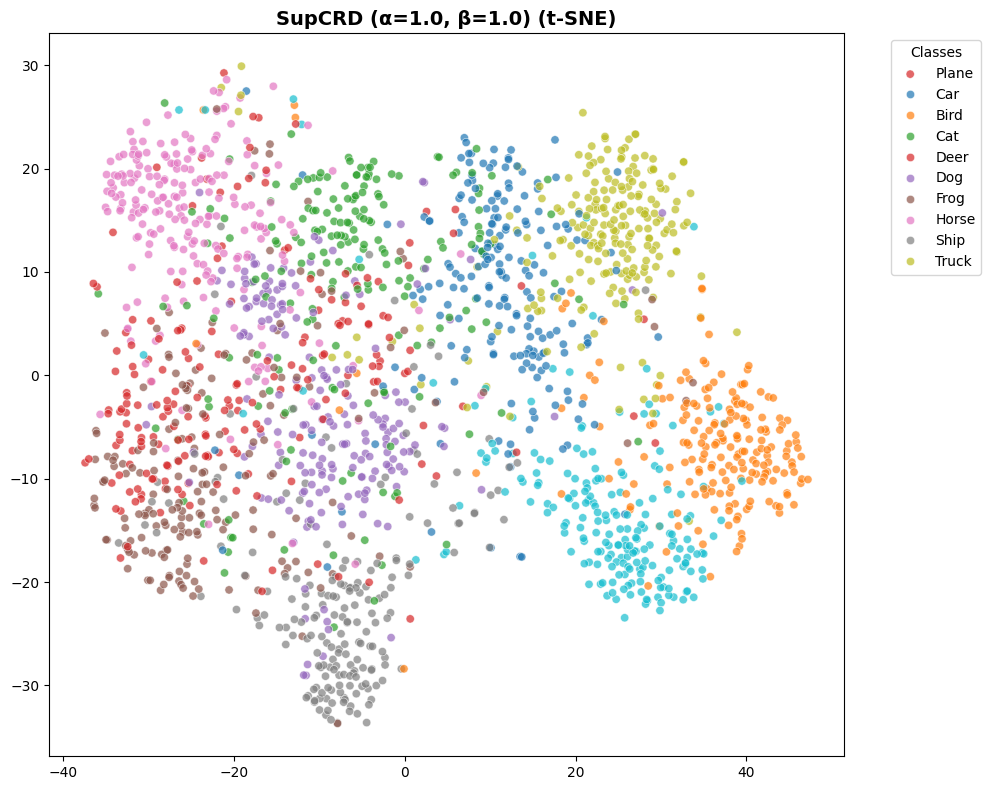


############################################################
Alpha Sweep: α=10.0
############################################################

TRAINING: Logit-Weighted SupCRD (Original)
α=10.0 (pull) | β=1.0 (push) | τ=0.07

Epoch  1/20: Loss=0.4676 | Probe Acc=40.71%
Epoch  2/20: Loss=0.2883 | Probe Acc=60.10%
Epoch  3/20: Loss=0.2163 | Probe Acc=67.25%
Epoch  4/20: Loss=0.1732 | Probe Acc=71.01%
Epoch  5/20: Loss=0.1487 | Probe Acc=73.25%
Epoch  6/20: Loss=0.1323 | Probe Acc=74.92%
Epoch  7/20: Loss=0.1194 | Probe Acc=75.92%
Epoch  8/20: Loss=0.1084 | Probe Acc=77.47%
Epoch  9/20: Loss=0.1009 | Probe Acc=78.26%
Epoch 10/20: Loss=0.0925 | Probe Acc=79.35%
Epoch 11/20: Loss=0.0875 | Probe Acc=80.04%
Epoch 12/20: Loss=0.0835 | Probe Acc=80.60%
Epoch 13/20: Loss=0.0789 | Probe Acc=81.45%
Epoch 14/20: Loss=0.0758 | Probe Acc=81.99%
Epoch 15/20: Loss=0.0724 | Probe Acc=82.59%
Epoch 16/20: Loss=0.0678 | Probe Acc=83.18%
Epoch 17/20: Loss=0.0663 | Probe Acc=83.87%
Epoch 18/20: Loss=0.0636 |

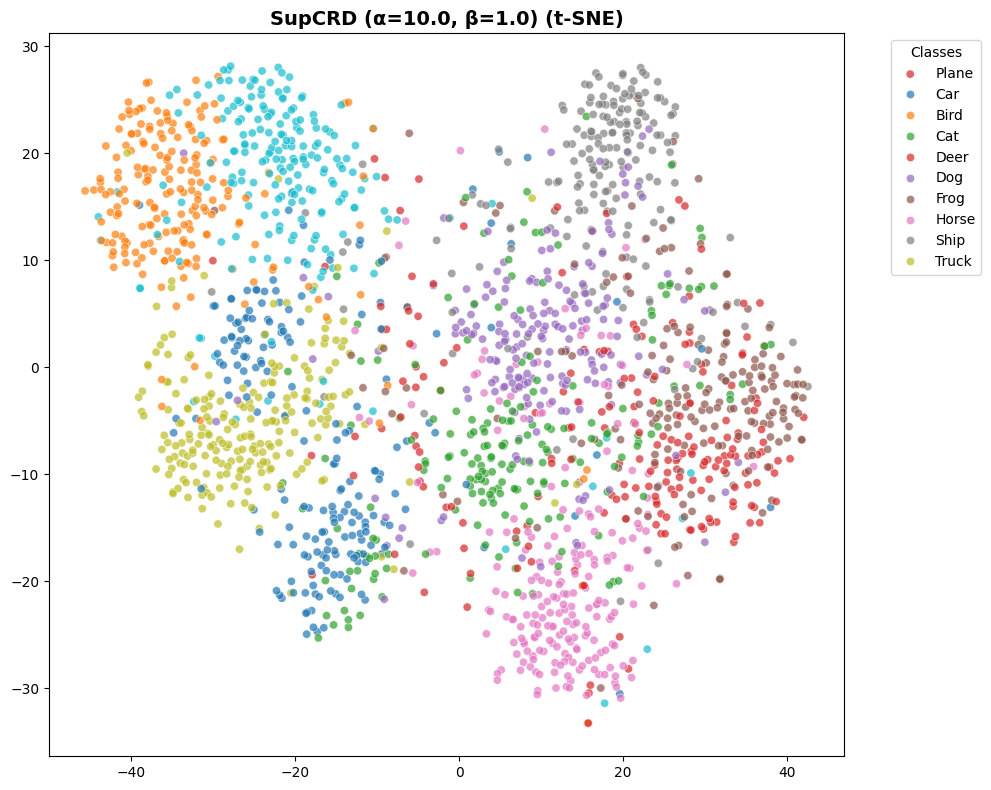


############################################################
Alpha Sweep: α=50.0
############################################################

TRAINING: Logit-Weighted SupCRD (Original)
α=50.0 (pull) | β=1.0 (push) | τ=0.07

Epoch  1/20: Loss=0.1552 | Probe Acc=37.62%
Epoch  2/20: Loss=0.1053 | Probe Acc=55.65%
Epoch  3/20: Loss=0.0776 | Probe Acc=63.23%
Epoch  4/20: Loss=0.0615 | Probe Acc=66.97%
Epoch  5/20: Loss=0.0493 | Probe Acc=70.01%
Epoch  6/20: Loss=0.0426 | Probe Acc=71.71%
Epoch  7/20: Loss=0.0373 | Probe Acc=73.01%
Epoch  8/20: Loss=0.0335 | Probe Acc=74.17%
Epoch  9/20: Loss=0.0302 | Probe Acc=75.34%
Epoch 10/20: Loss=0.0279 | Probe Acc=76.54%
Epoch 11/20: Loss=0.0252 | Probe Acc=77.09%
Epoch 12/20: Loss=0.0251 | Probe Acc=77.57%
Epoch 13/20: Loss=0.0231 | Probe Acc=78.47%
Epoch 14/20: Loss=0.0223 | Probe Acc=78.88%
Epoch 15/20: Loss=0.0211 | Probe Acc=79.58%
Epoch 16/20: Loss=0.0214 | Probe Acc=79.43%
Epoch 17/20: Loss=0.0193 | Probe Acc=80.50%
Epoch 18/20: Loss=0.0180 |

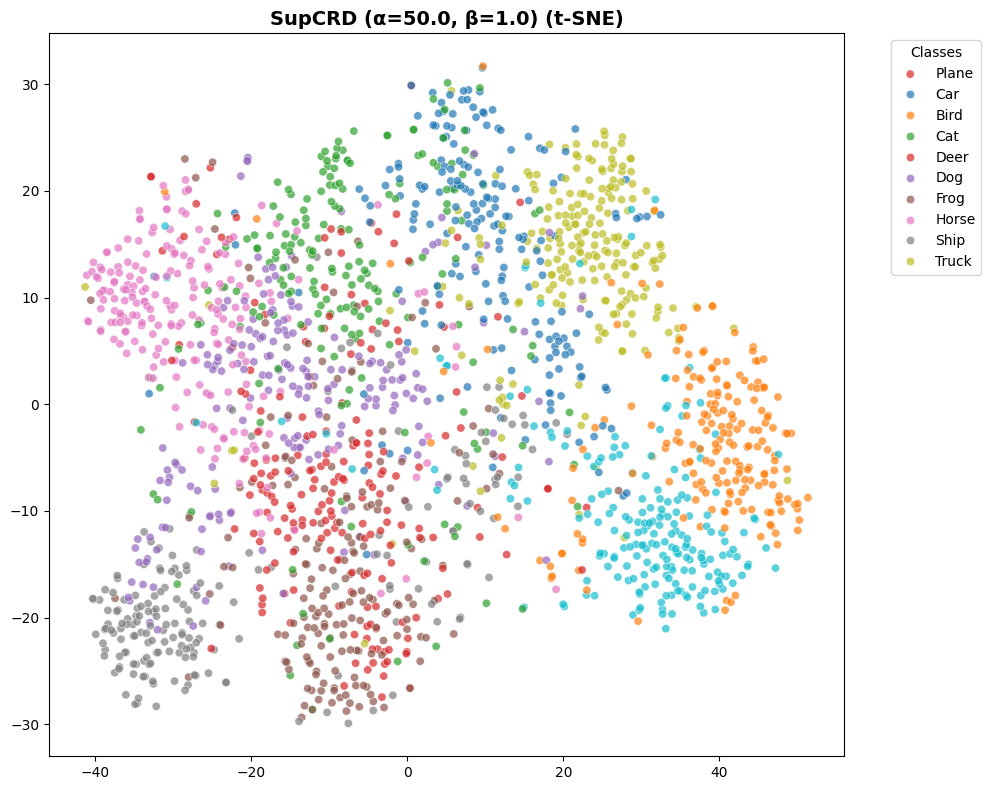

In [15]:
alpha_sweep_results = {}

for alpha in [1.0, 10.0, 50.0]:
    print(f"\n{'#'*60}")
    print(f"Alpha Sweep: α={alpha}")
    print(f"{'#'*60}")
    
    student, log = train_student(
        teacher_model=teacher,
        mode="supcrd",
        epochs=EPOCHS_STUDENT,
        alpha=alpha,
        beta=1.0,
        temperature=0.07
    )
    
    alpha_sweep_results[f"alpha_{alpha}"] = {
        'model': student,
        'log': log
    }
    
    visualize_latents(student, test_loader,
                      title=f"SupCRD (α={alpha}, β=1.0)",
                      save_path=f"supcrd_a{int(alpha)}_b1_latent.png")

## Experiment 6: Beta Sweep (α=1.0, τ=0.07)


############################################################
Beta Sweep: β=1.0
############################################################

TRAINING: Logit-Weighted SupCRD (Original)
α=1.0 (pull) | β=1.0 (push) | τ=0.07

Epoch  1/20: Loss=1.4855 | Probe Acc=44.76%
Epoch  2/20: Loss=0.8758 | Probe Acc=66.30%
Epoch  3/20: Loss=0.6863 | Probe Acc=72.55%
Epoch  4/20: Loss=0.5871 | Probe Acc=75.97%
Epoch  5/20: Loss=0.5272 | Probe Acc=78.08%
Epoch  6/20: Loss=0.4887 | Probe Acc=79.71%
Epoch  7/20: Loss=0.4464 | Probe Acc=81.33%
Epoch  8/20: Loss=0.4289 | Probe Acc=82.14%
Epoch  9/20: Loss=0.4063 | Probe Acc=83.05%
Epoch 10/20: Loss=0.3812 | Probe Acc=84.10%
Epoch 11/20: Loss=0.3609 | Probe Acc=85.03%
Epoch 12/20: Loss=0.3455 | Probe Acc=85.66%
Epoch 13/20: Loss=0.3326 | Probe Acc=86.32%
Epoch 14/20: Loss=0.3219 | Probe Acc=86.72%
Epoch 15/20: Loss=0.3158 | Probe Acc=86.85%
Epoch 16/20: Loss=0.2950 | Probe Acc=87.71%
Epoch 17/20: Loss=0.2866 | Probe Acc=88.11%
Epoch 18/20: Loss=0.2751 | Pr

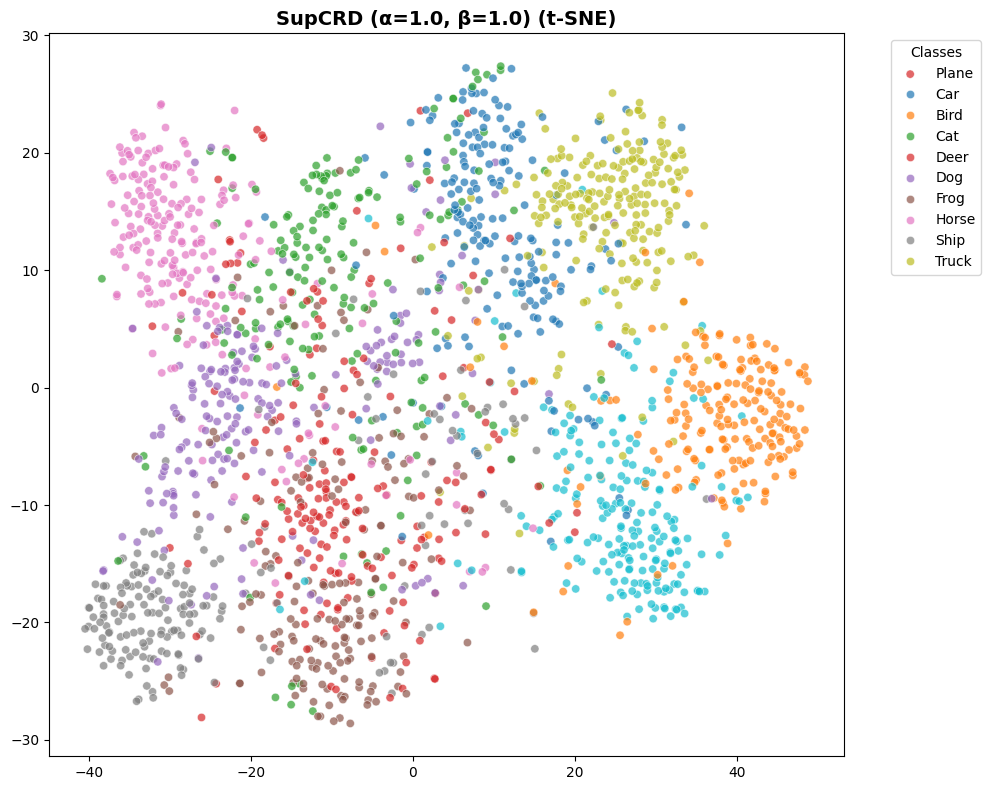


############################################################
Beta Sweep: β=10.0
############################################################

TRAINING: Logit-Weighted SupCRD (Original)
α=1.0 (pull) | β=10.0 (push) | τ=0.07

Epoch  1/20: Loss=3.0964 | Probe Acc=46.91%
Epoch  2/20: Loss=2.0757 | Probe Acc=68.08%
Epoch  3/20: Loss=1.7512 | Probe Acc=73.88%
Epoch  4/20: Loss=1.5835 | Probe Acc=77.05%
Epoch  5/20: Loss=1.4645 | Probe Acc=79.16%
Epoch  6/20: Loss=1.3799 | Probe Acc=80.88%
Epoch  7/20: Loss=1.3133 | Probe Acc=82.12%
Epoch  8/20: Loss=1.2429 | Probe Acc=83.31%
Epoch  9/20: Loss=1.1885 | Probe Acc=84.41%
Epoch 10/20: Loss=1.1440 | Probe Acc=85.29%
Epoch 11/20: Loss=1.1142 | Probe Acc=85.98%
Epoch 12/20: Loss=1.0747 | Probe Acc=86.58%
Epoch 13/20: Loss=1.0492 | Probe Acc=87.08%
Epoch 14/20: Loss=1.0039 | Probe Acc=87.84%
Epoch 15/20: Loss=0.9847 | Probe Acc=88.08%
Epoch 16/20: Loss=0.9610 | Probe Acc=88.65%
Epoch 17/20: Loss=0.9460 | Probe Acc=88.90%
Epoch 18/20: Loss=0.9178 | 

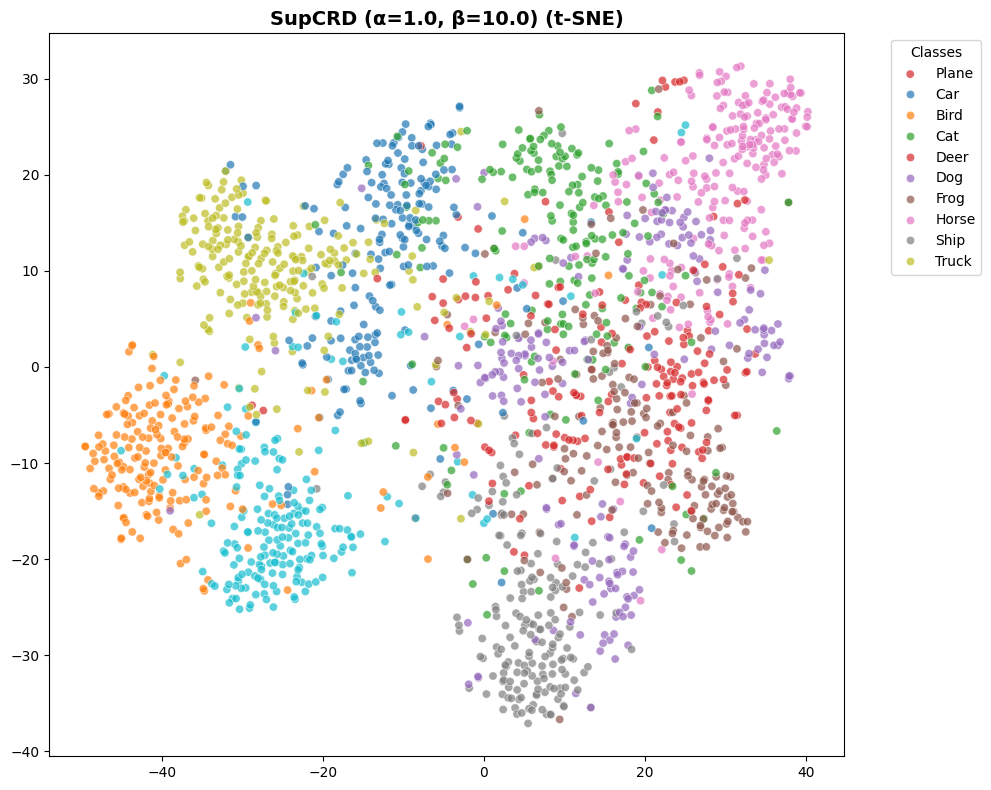


############################################################
Beta Sweep: β=50.0
############################################################

TRAINING: Logit-Weighted SupCRD (Original)
α=1.0 (pull) | β=50.0 (push) | τ=0.07

Epoch  1/20: Loss=4.5903 | Probe Acc=45.33%
Epoch  2/20: Loss=3.3777 | Probe Acc=65.68%
Epoch  3/20: Loss=2.9718 | Probe Acc=71.64%
Epoch  4/20: Loss=2.7430 | Probe Acc=74.84%
Epoch  5/20: Loss=2.5896 | Probe Acc=77.18%
Epoch  6/20: Loss=2.4847 | Probe Acc=78.35%
Epoch  7/20: Loss=2.3876 | Probe Acc=79.78%
Epoch  8/20: Loss=2.3060 | Probe Acc=81.06%
Epoch  9/20: Loss=2.2516 | Probe Acc=82.05%
Epoch 10/20: Loss=2.1695 | Probe Acc=82.89%
Epoch 11/20: Loss=2.1273 | Probe Acc=83.53%
Epoch 12/20: Loss=2.0823 | Probe Acc=84.15%
Epoch 13/20: Loss=2.0482 | Probe Acc=84.59%
Epoch 14/20: Loss=2.0107 | Probe Acc=84.98%
Epoch 15/20: Loss=1.9718 | Probe Acc=85.71%
Epoch 16/20: Loss=1.9364 | Probe Acc=86.05%
Epoch 17/20: Loss=1.9170 | Probe Acc=86.26%
Epoch 18/20: Loss=1.8866 | 

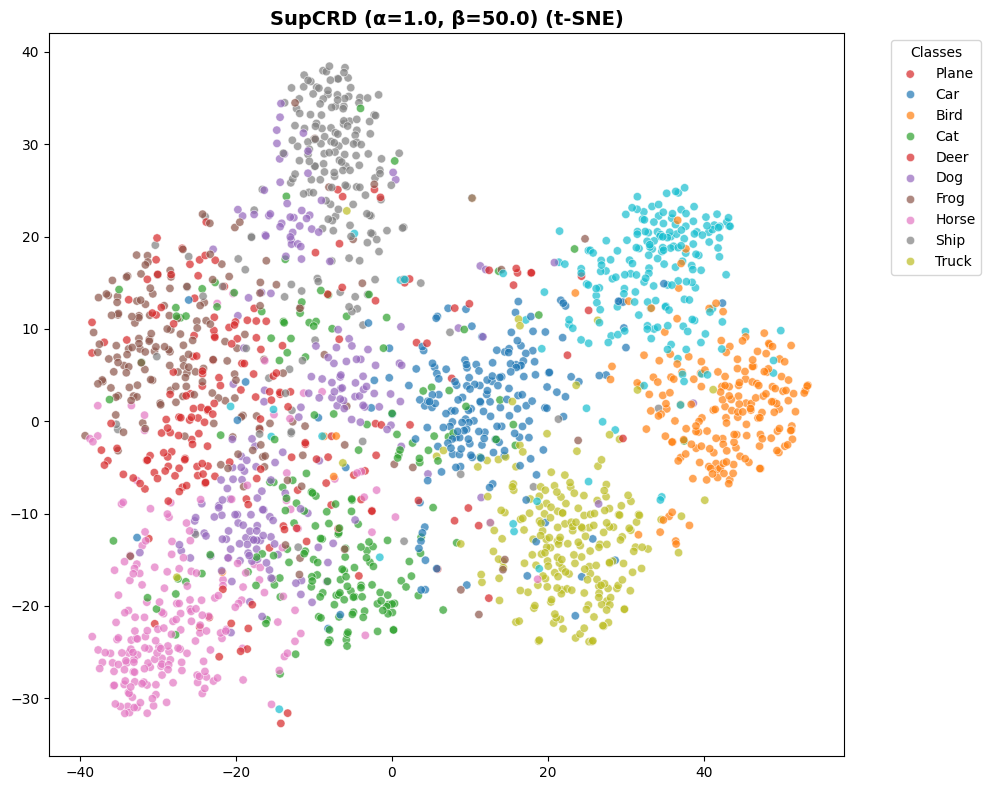

In [16]:
beta_sweep_results = {}

for beta in [1.0, 10.0, 50.0]:
    print(f"\n{'#'*60}")
    print(f"Beta Sweep: β={beta}")
    print(f"{'#'*60}")
    
    student, log = train_student(
        teacher_model=teacher,
        mode="supcrd",
        epochs=EPOCHS_STUDENT,
        alpha=1.0,
        beta=beta,
        temperature=0.07
    )
    
    beta_sweep_results[f"beta_{beta}"] = {
        'model': student,
        'log': log
    }
    
    visualize_latents(student, test_loader,
                      title=f"SupCRD (α=1.0, β={beta})",
                      save_path=f"supcrd_a1_b{int(beta)}_latent.png")

## Experiment 7: Balanced SupCRD


TRAINING: Balanced SupCRD (Force-Normalized)
α=1.0 (pull) | β=1.0 (push) | τ=0.07

Epoch  1/20: Loss=0.0421 | Probe Acc=38.02%
Epoch  2/20: Loss=0.0250 | Probe Acc=57.36%
Epoch  3/20: Loss=0.0178 | Probe Acc=64.09%
Epoch  4/20: Loss=0.0141 | Probe Acc=68.17%
Epoch  5/20: Loss=0.0115 | Probe Acc=70.74%
Epoch  6/20: Loss=0.0092 | Probe Acc=72.82%
Epoch  7/20: Loss=0.0080 | Probe Acc=74.40%
Epoch  8/20: Loss=0.0073 | Probe Acc=75.29%
Epoch  9/20: Loss=0.0063 | Probe Acc=76.63%
Epoch 10/20: Loss=0.0058 | Probe Acc=77.59%
Epoch 11/20: Loss=0.0053 | Probe Acc=78.54%
Epoch 12/20: Loss=0.0048 | Probe Acc=79.31%
Epoch 13/20: Loss=0.0051 | Probe Acc=79.30%
Epoch 14/20: Loss=0.0044 | Probe Acc=80.37%
Epoch 15/20: Loss=0.0044 | Probe Acc=80.63%
Epoch 16/20: Loss=0.0048 | Probe Acc=80.04%
Epoch 17/20: Loss=0.0034 | Probe Acc=82.74%
Epoch 18/20: Loss=0.0036 | Probe Acc=82.82%
Epoch 19/20: Loss=0.0059 | Probe Acc=79.49%
Epoch 20/20: Loss=0.0035 | Probe Acc=82.97%

✓ Student training complete: 82.97%

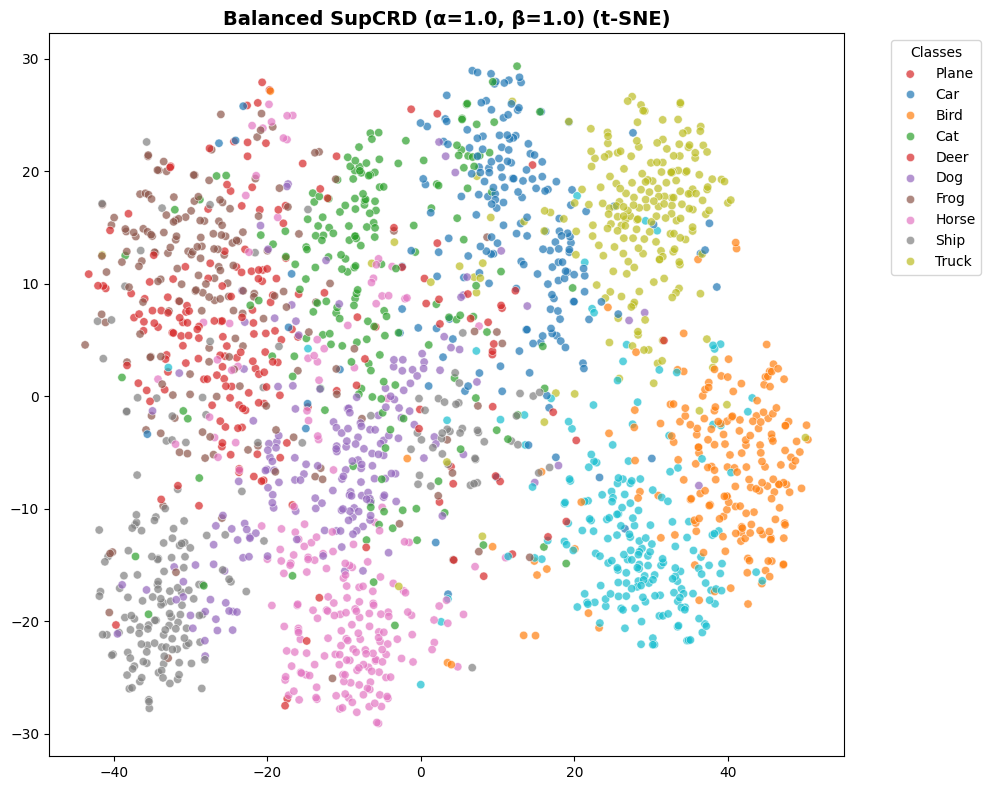

In [17]:
balanced_student, balanced_log = train_student(
    teacher_model=teacher,
    mode="balanced_supcrd",
    epochs=EPOCHS_STUDENT,
    alpha=1.0,
    beta=1.0,
    temperature=0.07
)

visualize_latents(balanced_student, test_loader,
                  title="Balanced SupCRD (α=1.0, β=1.0)",
                  save_path="balanced_supcrd_latent.png")

## Pull vs Push Force Analysis

This analysis measures the actual magnitude of pull forces (toward same-class samples) vs push forces (away from different-class samples) to verify if they're mathematically coupled.

In [18]:
# Create loss instances for analysis
supcrd_a1_b1_loss = LogitWeightedSupCRDLoss(alpha=1.0, beta=1.0, temperature=0.07)
supcrd_a1_b10_loss = LogitWeightedSupCRDLoss(alpha=1.0, beta=10.0, temperature=0.07)
supcrd_a10_b1_loss = LogitWeightedSupCRDLoss(alpha=10.0, beta=1.0, temperature=0.07)
supcrd_a50_b1_loss = LogitWeightedSupCRDLoss(alpha=50.0, beta=1.0, temperature=0.07)
supcrd_a1_b50_loss = LogitWeightedSupCRDLoss(alpha=1.0, beta=50.0, temperature=0.07)
balanced_loss = BalancedLogitWeightedSupCRDLoss(alpha=1.0, beta=1.0, temperature=0.07)

# Get models
supcrd_a1_b1_student = alpha_sweep_results['alpha_1.0']['model']
supcrd_a10_b1_student = alpha_sweep_results['alpha_10.0']['model']
supcrd_a50_b1_student = alpha_sweep_results['alpha_50.0']['model']
supcrd_a1_b10_student = beta_sweep_results['beta_10.0']['model']
supcrd_a1_b50_student = beta_sweep_results['beta_50.0']['model']

print("="*70)
print("PULL vs PUSH FORCE ANALYSIS")
print("="*70)

configs = [
    ('SupCRD α=1.0, β=1.0', supcrd_a1_b1_student, supcrd_a1_b1_loss),
    ('SupCRD α=1.0, β=10.0', supcrd_a1_b10_student, supcrd_a1_b10_loss),
    ('SupCRD α=1.0, β=50.0', supcrd_a1_b50_student, supcrd_a1_b50_loss),
    ('SupCRD α=10.0, β=1.0', supcrd_a10_b1_student, supcrd_a10_b1_loss),
    ('SupCRD α=50.0, β=1.0', supcrd_a50_b1_student, supcrd_a50_b1_loss),
    ('Balanced SupCRD α=1.0, β=1.0', balanced_student, balanced_loss),
]

for name, student, loss_fn in configs:
    print(f"\n{name}:")
    print("-" * 70)
    
    stats = analyze_pull_push_forces(student, teacher, test_loader, loss_fn)
    
    print(f"  Pull Force: mean={stats['pull_force']['mean']:.4f}, "
          f"std={stats['pull_force']['std']:.4f}")
    print(f"  Push Force: mean={stats['push_force']['mean']:.4f}, "
          f"std={stats['push_force']['std']:.4f}")
    print(f"  Pull Weight (α×p_target): mean={stats['pull_weight']['mean']:.4f}")
    print(f"  Push Weight (β×(1-p_neg)): mean={stats['push_weight']['mean']:.4f}")
    print(f"  **Ratio (Pull/Push): {stats['ratio_pull_to_push']:.4f}**")

print("\n" + "="*70)

PULL vs PUSH FORCE ANALYSIS

SupCRD α=1.0, β=1.0:
----------------------------------------------------------------------
  Pull Force: mean=14930.8232, std=18311.0234
  Push Force: mean=4034.8210, std=6385.3516
  Pull Weight (α×p_target): mean=0.7081
  Push Weight (β×(1-p_neg)): mean=0.8960
  **Ratio (Pull/Push): 3.7005**

SupCRD α=1.0, β=10.0:
----------------------------------------------------------------------
  Pull Force: mean=13207.7324, std=15694.9951
  Push Force: mean=31919.1250, std=55098.5430
  Pull Weight (α×p_target): mean=0.7081
  Push Weight (β×(1-p_neg)): mean=8.9597
  **Ratio (Pull/Push): 0.4138**

SupCRD α=1.0, β=50.0:
----------------------------------------------------------------------
  Pull Force: mean=13731.7373, std=16494.8164
  Push Force: mean=163565.4375, std=338894.1250
  Pull Weight (α×p_target): mean=0.7081
  Push Weight (β×(1-p_neg)): mean=44.7987
  **Ratio (Pull/Push): 0.0840**

SupCRD α=10.0, β=1.0:
----------------------------------------------------

## Semantic Similarity Analysis

In [19]:
semantic_pairs = [
    ('dog', 'cat'),   # Should be similar (both animals)
    ('dog', 'deer'),  # Should be similar (both animals)
    ('dog', 'car'),   # Should be distant
    ('dog', 'truck'), # Should be distant
    ('cat', 'dog'),   # Should be similar
    ('cat', 'car'),   # Should be distant
    ('plane', 'ship'), # Both vehicles, should be similar
    ('plane', 'bird'), # Could be similar (both fly)
]

print("\n" + "="*70)
print("SEMANTIC SIMILARITY ANALYSIS")
print("="*70)

models_to_analyze = [
    ('Baseline SupCon', baseline_student),
    ('SupCRD (α=1, β=1)', supcrd_a1_b1_student),
    ('SupCRD (α=1, β=10)', supcrd_a1_b10_student),
    ('Balanced SupCRD', balanced_student),
]

for name, model in models_to_analyze:
    print(f"\n{name}:")
    print("-" * 70)
    sims = compute_semantic_similarities(model, test_loader, semantic_pairs)
    for pair, sim in sims.items():
        print(f"  {pair:20s}: {sim:.4f}")

print("\n" + "="*70)


SEMANTIC SIMILARITY ANALYSIS

Baseline SupCon:
----------------------------------------------------------------------
  dog-cat             : 0.9579
  dog-deer            : 0.7183
  dog-car             : 0.2665
  dog-truck           : 0.3243
  cat-dog             : 0.9579
  cat-car             : 0.3342
  plane-ship          : 0.7274
  plane-bird          : 0.6154

SupCRD (α=1, β=1):
----------------------------------------------------------------------
  dog-cat             : 0.9033
  dog-deer            : 0.5876
  dog-car             : 0.1753
  dog-truck           : 0.2912
  cat-dog             : 0.9033
  cat-car             : 0.2655
  plane-ship          : 0.7240
  plane-bird          : 0.6711

SupCRD (α=1, β=10):
----------------------------------------------------------------------
  dog-cat             : 0.9035
  dog-deer            : 0.6688
  dog-car             : 0.3043
  dog-truck           : 0.4342
  cat-dog             : 0.9035
  cat-car             : 0.4209
  plane-ship    

---
---
# RESULTS & ANALYSIS
---

## Training Curves Comparison

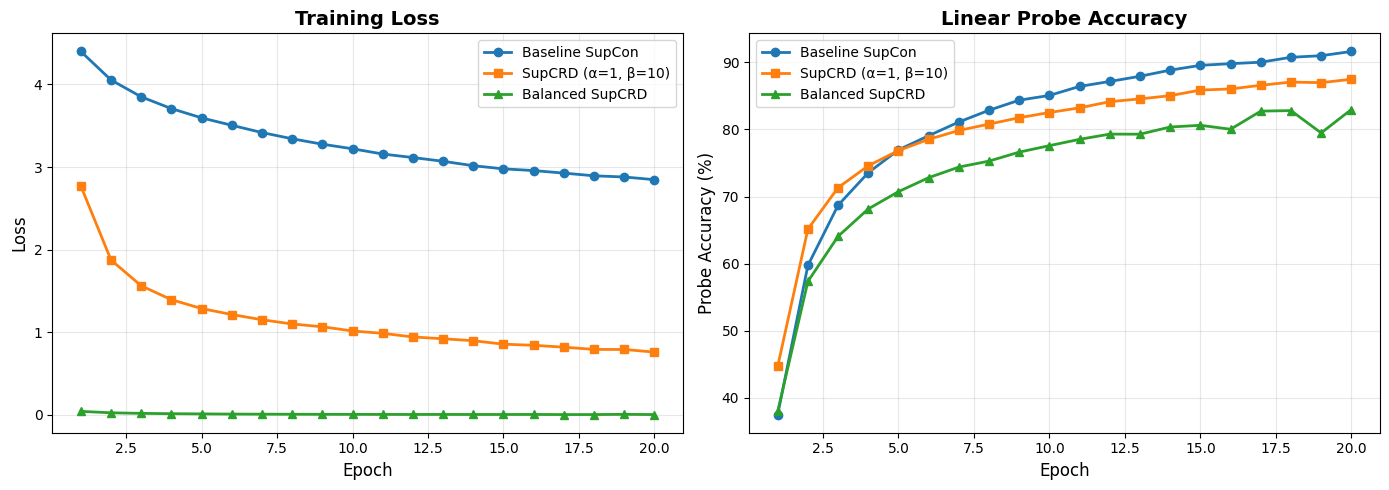

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(baseline_log['epochs'], baseline_log['loss'], 'o-', label='Baseline SupCon', linewidth=2)
ax1.plot(supcrd_log_1['epochs'], supcrd_log_1['loss'], 's-', label='SupCRD (α=1, β=10)', linewidth=2)
ax1.plot(balanced_log['epochs'], balanced_log['loss'], '^-', label='Balanced SupCRD', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(baseline_log['epochs'], baseline_log['probe_acc'], 'o-', label='Baseline SupCon', linewidth=2)
ax2.plot(supcrd_log_1['epochs'], supcrd_log_1['probe_acc'], 's-', label='SupCRD (α=1, β=10)', linewidth=2)
ax2.plot(balanced_log['epochs'], balanced_log['probe_acc'], '^-', label='Balanced SupCRD', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Probe Accuracy (%)', fontsize=12)
ax2.set_title('Linear Probe Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Alpha Sweep Results

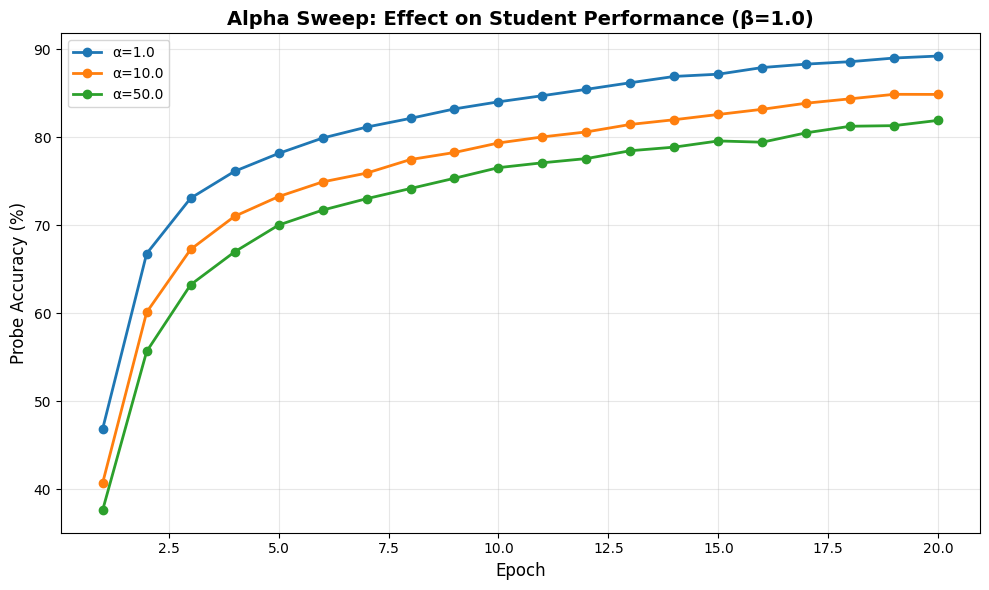

In [21]:
plt.figure(figsize=(10, 6))

for name, data in alpha_sweep_results.items():
    alpha_val = name.split('_')[1]
    plt.plot(data['log']['epochs'], data['log']['probe_acc'], 
             'o-', label=f'α={alpha_val}', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Probe Accuracy (%)', fontsize=12)
plt.title('Alpha Sweep: Effect on Student Performance (β=1.0)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('alpha_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

## Beta Sweep Results

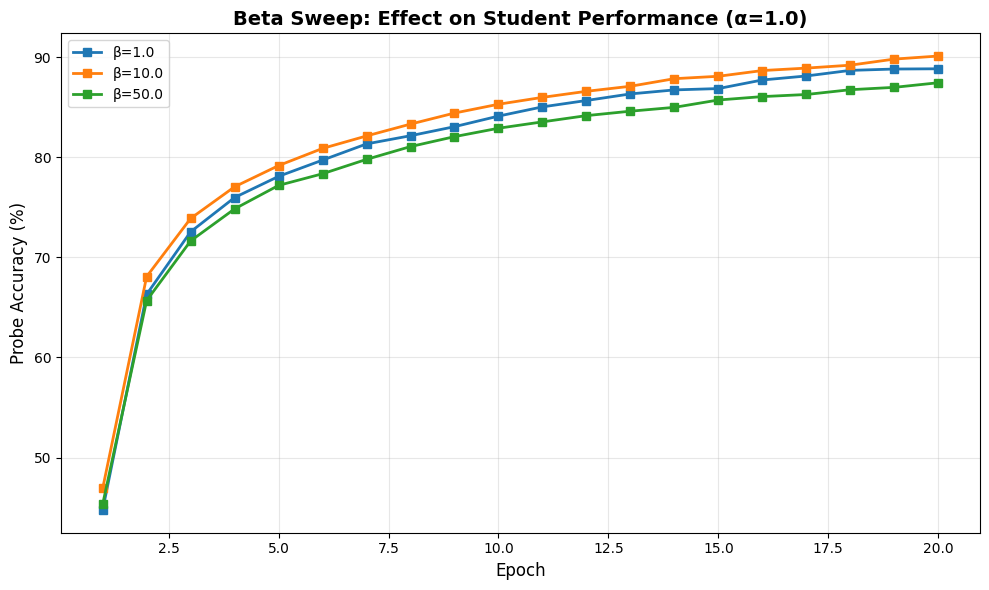

In [22]:
plt.figure(figsize=(10, 6))

for name, data in beta_sweep_results.items():
    beta_val = name.split('_')[1]
    plt.plot(data['log']['epochs'], data['log']['probe_acc'], 
             's-', label=f'β={beta_val}', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Probe Accuracy (%)', fontsize=12)
plt.title('Beta Sweep: Effect on Student Performance (α=1.0)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('beta_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

## Final Summary Table

In [23]:
summary_data = {
    'Method': [
        'Teacher',
        'Baseline SupCon',
        'SupCRD (α=1, β=10)',
        'SupCRD (α=1, β=1)',
        'Balanced SupCRD (α=1, β=1)'
    ],
    'Final Accuracy (%)': [
        88.2,
        baseline_log['probe_acc'][-1],
        supcrd_log_1['probe_acc'][-1],
        alpha_sweep_results['alpha_1.0']['log']['probe_acc'][-1],
        balanced_log['probe_acc'][-1]
    ],
    'Final Loss': [
        0.342,
        baseline_log['loss'][-1],
        supcrd_log_1['loss'][-1],
        alpha_sweep_results['alpha_1.0']['log']['loss'][-1],
        balanced_log['loss'][-1]
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)


FINAL RESULTS SUMMARY
                    Method  Final Accuracy (%)  Final Loss
                   Teacher              88.200    0.342000
           Baseline SupCon              91.622    2.846763
        SupCRD (α=1, β=10)              87.484    0.759537
         SupCRD (α=1, β=1)              89.230    0.265993
Balanced SupCRD (α=1, β=1)              82.974    0.003483


---
## Key Findings

**TODO**: Document your observations here:

### 1. Pull vs Push Coupling
- Original SupCRD: Check if ratio ≈ 1.0 (indicating coupling)
- Balanced SupCRD: Should have ratio = 1.0 by design
- Impact on performance?

### 2. Semantic Structure
- Does sim(dog, cat) > sim(dog, car)?
- Which method shows clearest semantic ordering?
- Is Balanced SupCRD better at preserving semantic structure?

### 3. Alpha/Beta Effects
- High α (pull): Impact on intra-class diversity
- High β (push): Impact on inter-class separation
- Optimal balance?

### 4. Balanced vs Original SupCRD
- Performance comparison
- Stability across batch sizes?
- True α/β independence?

### 5. Open Questions
- Should Pull = Push always?
- Why does Baseline SupCon still perform best?
- Is the 0.9% gap acceptable for semantic structure benefits?